In [5]:
from visualization import HiderSeekerEnv
import numpy as np
import random
import pygame
import os
import tensorflow as tf
import matplotlib.pyplot as plt



In [8]:
class QLearningAgent:
    def __init__(self, env, learning_rate=0.1, discount_factor=0.9, exploration_rate=1.0, exploration_decay=0.995, learning_rate_decay=0.999):
        self.env = env
        self.learning_rate = learning_rate  # Initial learning rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.learning_rate_decay = learning_rate_decay  # Add learning rate decay parameter
        
        self.q_table = {}  # Q-table: state-action -> value
        
        # Tracking variables
        self.episode_rewards = []
        self.episode_steps = []  # Track steps per episode
        self.exploration_rates = []
        self.loss_values = []  # Placeholder for loss (optional for Q-Learning)
        self.cumulative_rewards = []
        self.learning_rates = []  # List to track learning rate per episode

        # TensorBoard setup
        self.log_dir = "logs/q_learning"
        self.writer = tf.summary.create_file_writer(self.log_dir)

    def get_q_value(self, state, action):
        if state not in self.q_table:
            self.q_table[state] = {a: 0 for a in range(len(self.env.actions))}
        return self.q_table[state].get(action, 0)

    def choose_action(self, state):
        if random.uniform(0, 1) < self.exploration_rate:
            return random.choice(range(len(self.env.actions)))  # Explore
        else:
            q_values = [self.get_q_value(state, action) for action in range(len(self.env.actions))]
            return np.argmax(q_values)  # Exploit

    def update_q_table(self, state, action, reward, next_state):
        max_future_q = max([self.get_q_value(next_state, next_action) for next_action in range(len(self.env.actions))])
        current_q = self.get_q_value(state, action)
        new_q = current_q + self.learning_rate * (reward + self.discount_factor * max_future_q - current_q)
        if state not in self.q_table:
            self.q_table[state] = {}
        self.q_table[state][action] = new_q
        # Record a pseudo loss value for visualization (optional for Q-Learning)
        self.loss_values.append(abs(new_q - current_q))
        pass

    def log_metrics(self, episode):
        # Log metrics to TensorBoard
        with self.writer.as_default():
            tf.summary.scalar("Exploration Rate", self.exploration_rate, step=episode)
            tf.summary.scalar("Cumulative Reward", sum(self.episode_rewards), step=episode)
            tf.summary.scalar("Episode Reward", self.episode_rewards[-1], step=episode)
            tf.summary.scalar("Learning Rate", self.learning_rate, step=episode)  # Log learning rate
            self.writer.flush()

    def train(self, episodes=2500):
        for episode in range(episodes):
            state = self.env.reset()
            done = False
            total_reward = 0
            total_steps = 0

            while not done:
                action = self.choose_action(state)
                next_state, reward, done = self.env.step(self.env.actions[action])
                self.update_q_table(state, action, reward, next_state)
                state = next_state
                total_reward += reward
                total_steps += 1
                
            print(f"Episode {episode + 1}/{episodes} | Total Reward: {total_reward:.2f} | Steps: {total_steps} | Exploration Rate: {self.exploration_rate:.4f}")
            # Store the total reward and steps for each episode
            self.episode_rewards.append(total_reward)
            self.episode_steps.append(total_steps)

            # Decay exploration rate and track metrics
            self.exploration_rate *= self.exploration_decay
            self.exploration_rates.append(self.exploration_rate)
            self.cumulative_rewards.append(sum(self.episode_rewards))

            # Decay learning rate after each episode
            self.learning_rate *= self.learning_rate_decay
            self.learning_rates.append(self.learning_rate)  # Track learning rate per episode

            # Log the metrics to TensorBoard
            self.log_metrics(episode)

            # Plot progress every 40 episodes
            if (episode + 1) % 40 == 0:
                self.plot_progress(episode)

    def plot_steps(self):
        plt.figure(figsize=(14, 6))
        # Plot total steps per episode
        plt.plot(self.episode_steps, label="Total Steps per Episode", color='green')
        plt.xlabel("Episode")
        plt.ylabel("Total Steps")
        plt.title("Total Steps per Episode")
        plt.legend()

        plt.tight_layout()
        plt.show()

    def plot_progress(self, episode):
        output_folder = "EXP_1"
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

        plt.figure(figsize=(16, 12))

        # Plot loss curve
        plt.subplot(2, 2, 2)
        plt.plot(self.loss_values, label="Loss", color="red")
        plt.xlabel("Steps")
        plt.ylabel("Loss")
        plt.title("Loss Curve")
        plt.legend()

        # Plot exploration rate
        plt.subplot(2, 2, 3)
        plt.plot(self.exploration_rates, label="Exploration Rate", color="green")
        plt.xlabel("Episode")
        plt.ylabel("Exploration Rate")
        plt.title("Exploration Rate Over Time")
        plt.legend()

        # Plot learning rate
        plt.subplot(2, 2, 4)
        plt.plot(self.learning_rates, label="Learning Rate", color="orange")
        plt.xlabel("Episode")
        plt.ylabel("Learning Rate")
        plt.title("Learning Rate Over Time")
        plt.legend()

        # Plot total rewards per episode
        plt.subplot(2, 2, 1)
        plt.plot(self.episode_rewards, label="Total Reward per Episode", color='blue')
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")
        plt.title("Total Reward per Episode")
        plt.legend()
        
        plt.tight_layout()

        # Save instead of showing
        plot_filename = os.path.join(output_folder, f"progress_after_{episode}_episodes.png")
        plt.savefig(plot_filename)
        plt.close()


Episode 1/2500 | Total Reward: 68.50 | Steps: 10 | Exploration Rate: 1.0000
Episode 2/2500 | Total Reward: 69.50 | Steps: 11 | Exploration Rate: 0.9950
Episode 3/2500 | Total Reward: -16.50 | Steps: 33 | Exploration Rate: 0.9900
Episode 4/2500 | Total Reward: -195.50 | Steps: 97 | Exploration Rate: 0.9851
Episode 5/2500 | Total Reward: -64.50 | Steps: 61 | Exploration Rate: 0.9801
Episode 6/2500 | Total Reward: 36.00 | Steps: 19 | Exploration Rate: 0.9752
Episode 7/2500 | Total Reward: 10.50 | Steps: 37 | Exploration Rate: 0.9704
Episode 8/2500 | Total Reward: 66.50 | Steps: 12 | Exploration Rate: 0.9655
Episode 9/2500 | Total Reward: -38.50 | Steps: 47 | Exploration Rate: 0.9607
Episode 10/2500 | Total Reward: 65.50 | Steps: 11 | Exploration Rate: 0.9559
Episode 11/2500 | Total Reward: -81.00 | Steps: 55 | Exploration Rate: 0.9511
Episode 12/2500 | Total Reward: -193.00 | Steps: 101 | Exploration Rate: 0.9464
Episode 13/2500 | Total Reward: 68.00 | Steps: 10 | Exploration Rate: 0.9416

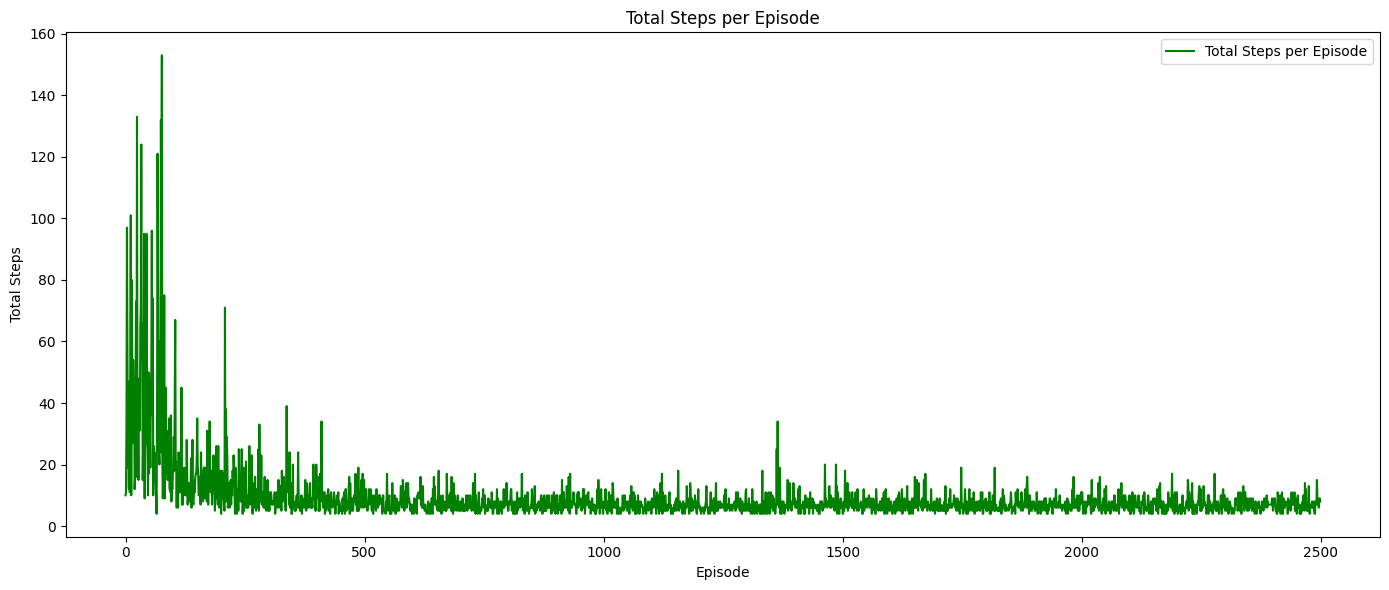

In [9]:

# Initialize environment and agent
env = HiderSeekerEnv(grid_size=5)
agent = QLearningAgent(env)

# Train agent with TensorBoard logging
agent.train(episodes=2500)

# Plot total rewards and total steps per episode
agent.plot_steps()

# Test agent
state = env.reset()
done = False
while not done:
    env.render()
    action = agent.choose_action(state)
    next_state, reward, done = env.step(env.actions[action])
    state = next_state

env.close()  # Close the pygame window after testing

## Command to check logs for Q-Learning
##### tensorboard --logdir=logs/q_learning